In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

from models import *
from kde_utils import *


In [2]:
## Create a gaussian mixture dummy dataset for torch
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [22]:
n_samples = 1000
n_features = 2
n_classes = 4
np.random.seed(10)
X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=np.exp(np.random.randn(n_classes)), random_state=10)

scaler = StandardScaler()
X = torch.from_numpy(scaler.fit_transform(X)).float()
## transform y to one-hot
y = torch.from_numpy(y)
y_one_hot = torch.nn.functional.one_hot(y).float()

In [23]:
#split into train and test
from sklearn.model_selection import train_test_split
X, X_test, y_one_hot, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


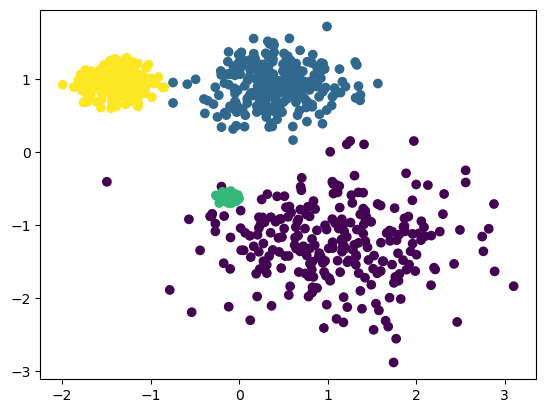

In [24]:
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [13]:
model_kwargs = {"latent_dim":3,
                "num_neurons":20,
                "num_hidden_layers":2,
                "learn_decoder_sigma":True,}

In [14]:
model = VAE(input_dim=X.shape[1], cond_dim=0, **model_kwargs)

In [15]:
train_kwargs = {"beta":1.0,
                "mc_samples":1,
                "lr":1e-3,
                "epochs":500,
                "verbose_freq":100,
                "batch_size":32,}

In [16]:
model.train(x=X, conditions=y_one_hot, **train_kwargs)

Iteration: 100/12500 -- ELBO=-2.96e+00 / RLL=-2.96e+00 / KL=5.51e-04
Iteration: 200/12500 -- ELBO=-2.92e+00 / RLL=-2.91e+00 / KL=7.57e-04
Iteration: 300/12500 -- ELBO=-2.56e+00 / RLL=-2.56e+00 / KL=2.80e-04
Iteration: 400/12500 -- ELBO=-3.11e+00 / RLL=-3.10e+00 / KL=1.04e-03
Iteration: 500/12500 -- ELBO=-2.66e+00 / RLL=-2.66e+00 / KL=2.87e-03
Iteration: 600/12500 -- ELBO=-2.87e+00 / RLL=-2.82e+00 / KL=4.42e-02
Iteration: 700/12500 -- ELBO=-1.91e+00 / RLL=-7.15e-01 / KL=1.20e+00
Iteration: 800/12500 -- ELBO=-1.03e+00 / RLL=9.38e-01 / KL=1.96e+00
Iteration: 900/12500 -- ELBO=-7.95e-01 / RLL=1.11e+00 / KL=1.91e+00
Iteration: 1000/12500 -- ELBO=-3.51e-01 / RLL=1.47e+00 / KL=1.82e+00
Iteration: 1100/12500 -- ELBO=-1.30e-01 / RLL=1.53e+00 / KL=1.66e+00
Iteration: 1200/12500 -- ELBO=-2.22e-01 / RLL=1.46e+00 / KL=1.68e+00
Iteration: 1300/12500 -- ELBO=1.44e-01 / RLL=1.87e+00 / KL=1.72e+00
Iteration: 1400/12500 -- ELBO=-1.69e-01 / RLL=1.35e+00 / KL=1.52e+00
Iteration: 1500/12500 -- ELBO=2.40e-0

KeyboardInterrupt: 

In [68]:
x_dict = model.sample(num_samples_prior=X.shape[0], conditions=y_one_hot[0])
samples = x_dict["samples"].flatten(end_dim=-2).detach()
# samples = x_dict["params"]["mu"].flatten(end_dim=-2).detach()

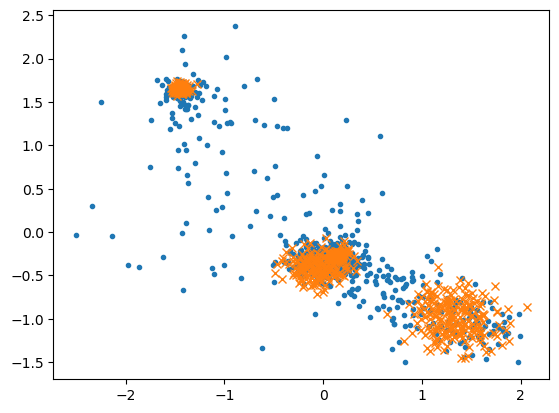

In [69]:
plt.plot(x_dict["samples"].flatten(end_dim=-2).detach().numpy()[:,0],x_dict["samples"].flatten(end_dim=-2).detach().numpy()[:,1],'.')
plt.plot(X[:,0],X[:,1],'x')
plt.show()

In [70]:
miss_idx = torch.rand(X.size())<0.3
test_data_miss = X.clone()
test_data_miss[miss_idx] = torch.nan

In [71]:
test_data_idx = [5,7]
X[test_data_idx]

tensor([[ 0.2506, -0.2217],
        [ 0.1487, -0.2809]])

In [72]:
test_data_miss[test_data_idx]

tensor([[    nan, -0.2217],
        [ 0.1487,     nan]])

In [73]:
model.impute(test_data_miss[[test_data_idx]], num_steps=200, use_mean=False)

tensor([[ 0.0124, -0.2217],
        [ 0.1487, -0.3591]])

In [74]:
from comparison import *
import seaborn as sns

In [75]:
train_data = X
test_data = X_test

In [96]:
sample_test = "mmd"
model_scores, base_scores = sample_comparison(model_samples=samples, train_samples=train_data, test_samples=test_data, test=sample_test, subsample_ratio=0.4, mc_runs=1000)

In [97]:
model_test = "cvm"
model_score = model_comparison(model_scores=model_scores, base_scores=base_scores, test=model_test)

[]

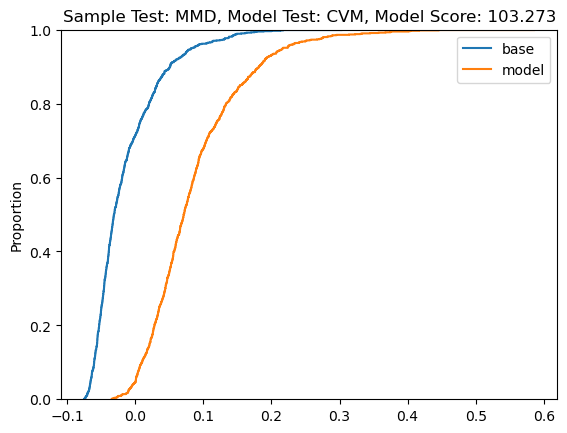

In [98]:
sns.ecdfplot(base_scores, label='base')
sns.ecdfplot(model_scores, label='model')
plt.legend()
plt.title(f"Sample Test: {sample_test.upper()}, Model Test: {model_test.upper()}, Model Score: {model_score:.3f}")
plt.plot()